In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from astroML.density_estimation import KNeighborsDensity
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm
from astroML.plotting import hist
%matplotlib inline

In [67]:
t = Table().read('/net/gooimeer/data1/juan/DBDM/DDM2017/Datasets/joint-bh-mass-table.csv')
print t

     Name      MBH  MBHLow MBHHigh
-------------- ---- ------ -------
 XTE J1118+480 7.55    6.9     8.2
 XTE J1550-564 10.5    9.5    11.5
    GS 2000+25 6.55     --      --
  GRO J0422+32 10.4     --      --
   GRS 1009-45  8.5     --      --
  GRS 1716-249  4.9     --      --
       GX339-4  7.0     --      --
      H1705-25  6.4    4.9     7.9
      A0620-00  6.6   6.35    6.85
XTEJ1650-50(0)  5.1     --      --
           ...  ...    ...     ...
    LVT151012b 13.0    8.0    17.0
     LVT151012 37.0   33.0    50.0
     GW151226a 14.2   10.5    22.5
     GW151226b  7.5    5.2     9.8
      GW151226 20.8   19.1    26.9
     GW170104a 31.2   25.2    39.6
     GW170104b 19.4   13.5    24.7
      GW170104 48.7   44.1    54.4
     GW170814a 32.0   28.0    36.0
     GW170814b 24.5   21.0    28.0
      GW170814 53.5   51.0    56.0
Length = 39 rows


In [68]:

def plot_histogram(t, binning_style, label, ax=None, xmin=-4, xmax=65):
    """
    Convenience routine for plotting a histogram.
    """

    if ax is not None:
        ax = plt.axes(ax)

    counts, bins, patches = hist(t, bins=binning_style, ax=ax,
                                 color='k', histtype='step', normed=True)
    ax.text(0.95, 0.93, '{0:s}:\n{1:d} bins'.format(label, len(counts)),
            transform=ax.transAxes, ha='right', va='top')

    # Turn off y-axis labeling.
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlim(xmin, xmax)

    return ax

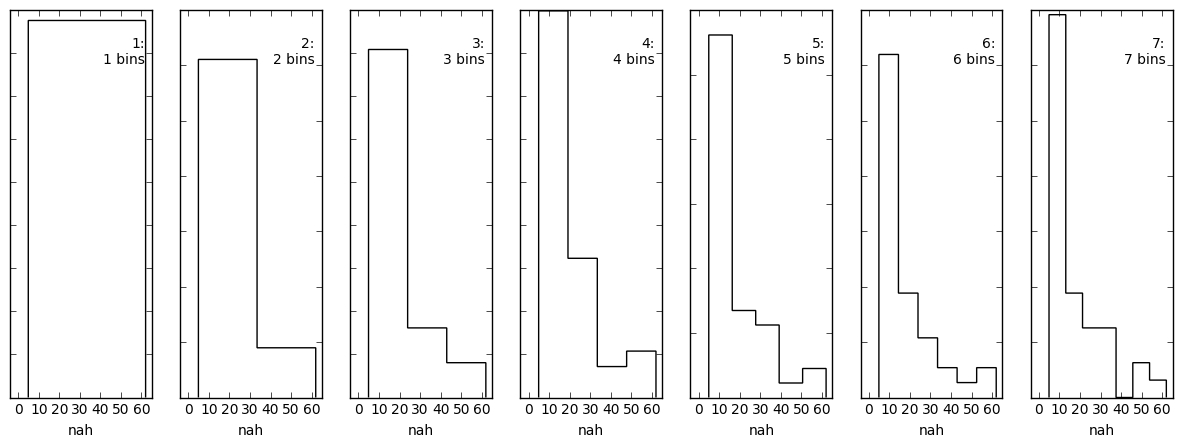

In [69]:
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
styles = [1,2,3,4,5,6,7]
titles = ["1", '2', '3', '4', '5', '6', '7']
for i in range(len(styles)):
    axis = plot_histogram(t['MBH'], styles[i], titles[i], ax=ax[i], xmin=-4, xmax=65)
    ax[i].set_xlabel('nah')

In [70]:
np.random.seed(1)
N = 150
i1 = np.int(0.2*N)
i2 = np.int(0.6*N)
X = np.concatenate((np.random.normal(30, 5, i1),
                    np.random.normal(20, 2, i2),
                   np.random.normal(50, 3, i1)))[:, np.newaxis]
np.random.shuffle(X)

#Nb = 3000
#Xbig = np.concatenate((np.random.normal(0, 1, i1),
#                    np.random.normal(5, 0.7, i2),
#                   np.random.normal(3, 0.2, i1)))[:, np.newaxis]

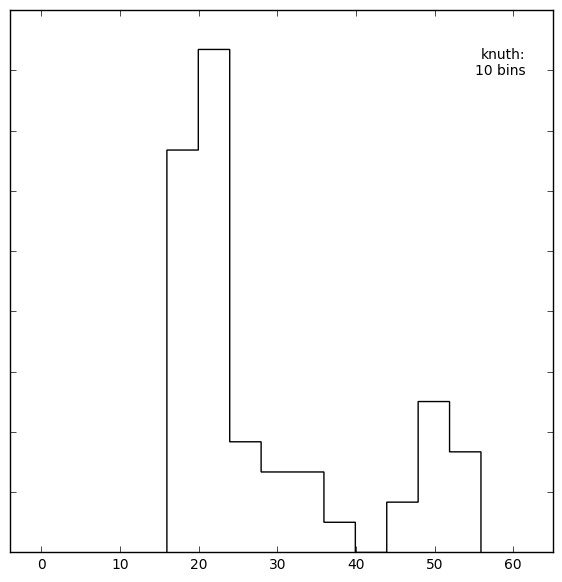

In [71]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plot_histogram(X[:,0], 10, 'knuth', ax=ax, xmin=-4, xmax=65)

In [72]:
from sklearn.model_selection import GridSearchCV

In [86]:
bws = np.linspace(0.01, 7, 500)
#params = {'bandwidth': bws}

In [87]:
from sklearn.cross_validation import KFold

def cv1(x, bws, model='gaussian', plot=False, n_folds=10):
    """
    This calculates the leave-one-out cross validation. If you set 
    plot to True, then it will show a big grid of the test and training
    samples with the KDE chosen at each step. You might need to modify the 
    code if you want a nicer layout :)
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_folds), figsize=(15, 8))
        xplot = np.linspace(-3, 8, 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(N, n_folds=n_folds)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf:
            x_train = x[train, :]
            x_test = x[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=model, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Calculate the average likelihood          
        cv_1[i] = lnP/N
        
    return cv_1


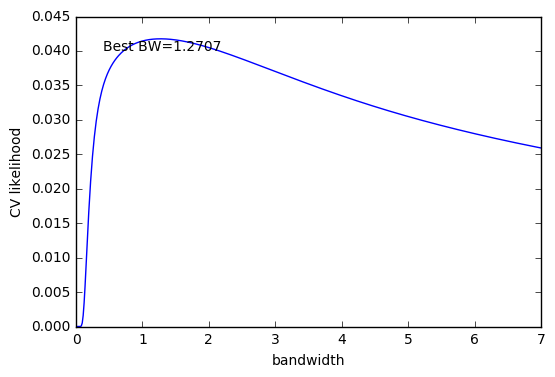

In [88]:
cv = cv1(X, bws)
plt.plot(bws, np.exp(cv))
plt.xlabel('bandwidth')
plt.ylabel('CV likelihood')
plt.text(0.4, 0.04, 'Best BW={0:.4f}'.format(bws[np.argmax(cv)]))

In [89]:
data = Table().read('/net/gooimeer/data1/juan/DBDM/DDM2017/Datasets/pulsar_masses.vot')
print t

     Name      MBH  MBHLow MBHHigh
-------------- ---- ------ -------
 XTE J1118+480 7.55    6.9     8.2
 XTE J1550-564 10.5    9.5    11.5
    GS 2000+25 6.55     --      --
  GRO J0422+32 10.4     --      --
   GRS 1009-45  8.5     --      --
  GRS 1716-249  4.9     --      --
       GX339-4  7.0     --      --
      H1705-25  6.4    4.9     7.9
      A0620-00  6.6   6.35    6.85
XTEJ1650-50(0)  5.1     --      --
           ...  ...    ...     ...
    LVT151012b 13.0    8.0    17.0
     LVT151012 37.0   33.0    50.0
     GW151226a 14.2   10.5    22.5
     GW151226b  7.5    5.2     9.8
      GW151226 20.8   19.1    26.9
     GW170104a 31.2   25.2    39.6
     GW170104b 19.4   13.5    24.7
      GW170104 48.7   44.1    54.4
     GW170814a 32.0   28.0    36.0
     GW170814b 24.5   21.0    28.0
      GW170814 53.5   51.0    56.0
Length = 39 rows
